In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import npc_lims
# from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils
from dynamic_routing_analysis import data_utils

import os
import pickle
import upath

%load_ext autoreload
%autoreload 2
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [326]:
session_id='742903_2024-10-22' #good DR
# session_id="664851_2023-11-13" #mediocre DR
# session_id="670180_2023-07-27" #templeton

session_info=npc_lims.get_session_info(session_id)
trials=data_utils.load_trials_or_units(session_info, 'trials', version='0.0.272')
units=data_utils.load_trials_or_units(session_info, 'units', version='0.0.272')

742903_2024-10-22 cached trials loaded
742903_2024-10-22 cached units loaded


In [327]:
# units_filtered['electrode_group_name']#.columns#['peak_channel']
trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'response_window_start_time', 'response_window_stop_time',
       'task_control_response_time', 'response_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'rewarded_modality', 'trial_index',
       'trial_index_in_block', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_instruction',
       'is_aud_stim', 'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarget',
       'is_vis_rewarded', 'is_aud_rewarded', 'is_block_switch', 'is_repeat',
       'is_opto', 'is_task_control_correct', 'session_idx

In [328]:
#make data array

units_filtered = units.query(
    'presence_ratio>=0.7 and \
    isi_violations_ratio<=0.5 and \
    amplitude_cutoff<=0.1 and \
    activity_drift<=0.2 and \
    firing_rate>=0.5 and \
    ~structure.isna() and ~location.isna()'
    ).sort_values(['electrode_group_name', 'peak_channel', 'unit_id'])

time_before = 0.0
time_after = 0.51
binsize = 0.5
trial_da = spike_utils.make_neuron_time_trials_tensor(units_filtered, trials, time_before, time_after, binsize)

In [329]:
trial_da

<xarray.DataArray (unit_id: 1442, time: 1, trials: 538)>
array([[[ 6.,  4.,  2., ...,  4.,  2.,  2.]],

       [[12., 12., 12., ...,  2.,  6., 12.]],

       [[ 2.,  0.,  2., ...,  0.,  0.,  0.]],

       ...,

       [[ 8., 14., 22., ...,  0.,  2.,  2.]],

       [[ 8.,  8., 10., ...,  0.,  4., 12.]],

       [[ 8.,  8., 16., ...,  0.,  0.,  6.]]])
Coordinates:
  * unit_id  (unit_id) object '742903_2024-10-22_A-0' ... '742903_2024-10-22_...
  * time     (time) float64 0.25
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 530 531 532 533 534 535 536 537

In [330]:
epochs=pd.read_parquet(npc_lims.get_cache_path(nwb_component='epochs', session_id=session_id, version='0.0.272'))
epochs

start_time    stop_time         script_name notes  \
id                                                      
0     44.79145   915.504433           RFMapping         
1    925.76399  1276.573301         OptoTagging         
2   1286.79894  1889.936699         Spontaneous         
3   1900.72890  2503.800740  SpontaneousRewards         
4   2514.35961  6155.325601     DynamicRouting1         
5   6166.13478  6769.256588  SpontaneousRewards         
6   6779.73208  7382.853794         Spontaneous         
7   7393.26257  7741.754331         OptoTagging         

                                    interval_names                    tags  \
id                                                                           
0   [vis_rf_mapping_trials, aud_rf_mapping_trials]               [mapping]   
1                             [optotagging_trials]           [optotagging]   
2                             [spontaneous_trials]           [spontaneous]   
3                     [spontaneous_rewards_trials]  [rewards, spontaneous]   
4                            [trials, performance]         [task, rewards]   
5                     [spontaneous_rewards_trials]  [rewards, spontaneous]   
6                             [spontaneous_trials]           [spontaneous]   
7                             [optotagging_trials]           [optotagging]   

    session_idx        date  subject_id         session_id  
id                                                          
0             0  2024-10-22      742903  742903_2024-10-22  
1             0  2024-10-22      742903  742903_2024-10-22  
2             0  2024-10-22      742903  742903_2024-10-22  
3             0  2024-10-22      742903  742903_2024-10-22  
4             0  2024-10-22      742903  742903_2024-10-22  
5             0  2024-10-22      742903  742903_2024-10-22  
6             0  2024-10-22      742903  742903_2024-10-22  
7             0  2024-10-22      742903  742903_2024-10-22

Text(0, 0.5, 'Count')

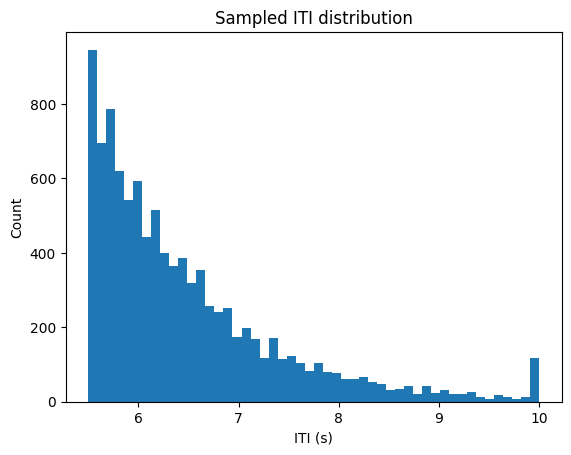

In [331]:
#generate ITIs with same statistics as the task

def generate_DR_ITI(n_samples=None,is_templeton=False):

    import random

    preStimFramesFixed = 90 # min frames between start of trial and stimulus onset
    preStimFramesVariableMean = 60 # mean of additional preStim frames drawn from exponential distribution
    preStimFramesMax = 360 # max total preStim frames
    # quiescentFrames = 90 # frames before stim onset during which licks delay stim onset
    responseWindow = [6,60]
    postResponseWindowFrames = 180

    if is_templeton:
        preStimFramesVariableMean = 30 
        preStimFramesMax = 240
        postResponseWindowFrames = 120

    if n_samples is not None:
        return [generate_DR_ITI() for _ in range(n_samples)]
    else:
        val = preStimFramesFixed + random.expovariate(1/preStimFramesVariableMean) if preStimFramesVariableMean > 1 else preStimFramesFixed + preStimFramesVariableMean
        trial_total_length = (int(min(val,preStimFramesMax)) + responseWindow[1] + postResponseWindowFrames)/60 #in seconds

        return trial_total_length

# sample_ITIs=[]
# for xx in range(10000):  # Generate 10000 samples
#     sample_ITIs.append(generate_DR_ITI())

sample_ITIs=generate_DR_ITI(n_samples=10000,is_templeton=False)

fig,ax=plt.subplots(1,1)
ax.hist(sample_ITIs, bins=50)
ax.set_title('Sampled ITI distribution')
ax.set_xlabel('ITI (s)')
ax.set_ylabel('Count')

In [332]:
#get spontaneous equivalent to trial_da - generate false trials using itis
# epochs.query('script_name.str.contains("Spontaneous")') #spont with & without rewards
# epochs.query('script_name=="Spontaneous"')

spont_trials={
    'start_time':[],
}

for rr,row in epochs.query('script_name.str.contains("Spontaneous") and id<4').iterrows():
    spont_start=row['start_time']
    spont_end=row['stop_time']
    spont_duration=spont_end-spont_start
    
    sampleITIs=generate_DR_ITI(n_samples=1000,is_templeton=False)
    cum_sampleITIs=np.cumsum(sampleITIs)
    valid_starts=spont_start+cum_sampleITIs[cum_sampleITIs+spont_start<spont_end]

    spont_trials['start_time'].append(valid_starts)

spont_trials['start_time'] = np.concatenate(spont_trials['start_time'])
spont_trials_df = pd.DataFrame(spont_trials)
time_before = 0.0
time_after = 0.51
binsize = 0.5
spont_trial_da = spike_utils.make_neuron_time_trials_tensor(units_filtered, spont_trials_df, time_before, time_after, binsize, event_name='start_time')
    


In [ ]:
# correlation between 1st PC across areas

In [333]:
# run pca on the data array
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(trial_da.data.reshape(trial_da.data.shape[0], -1).T)

transformed_data = pca.transform(trial_da.data.reshape(trial_da.data.shape[0], -1).T)


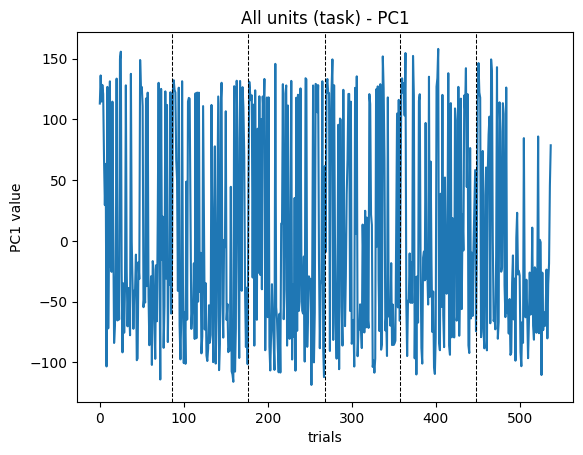

In [334]:
#all units
fig,ax=plt.subplots(1,1)
ax.plot(transformed_data[:,0])
ax.set_title('All units (task) - PC1')
ax.set_xlabel('trials')
ax.set_ylabel('PC1 value')
#plot block switches
for rr,row in trials.query('is_block_switch').iterrows():
    ax.axvline(row['trial_index']-0.5, color='k', linestyle='--', linewidth=0.75)

In [335]:
pca_spont = PCA()
pca_spont.fit(spont_trial_da.data.reshape(spont_trial_da.data.shape[0], -1).T)
transformed_data_spont = pca_spont.transform(spont_trial_da.data.reshape(spont_trial_da.data.shape[0], -1).T)
transformed_data_spont_by_task = pca.transform(spont_trial_da.data.reshape(spont_trial_da.data.shape[0], -1).T)

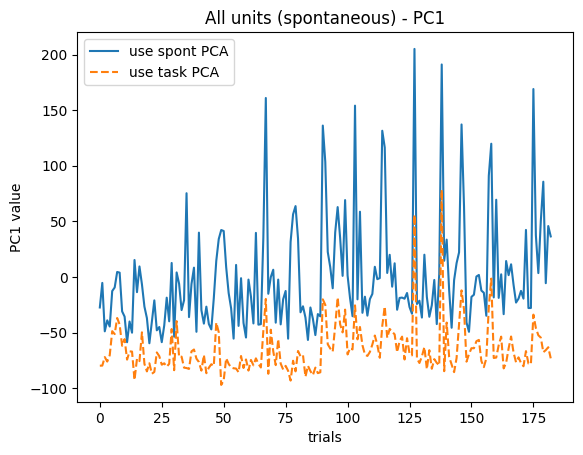

In [338]:
#all units - spontaneous activity
fig,ax=plt.subplots(1,1)
ax.plot(transformed_data_spont[:,0], label='use spont PCA')
ax.plot(transformed_data_spont_by_task[:,0], linestyle='--', label='use task PCA')
ax.set_title('All units (spontaneous) - PC1')
ax.set_xlabel('trials')
ax.set_ylabel('PC1 value')
ax.legend()

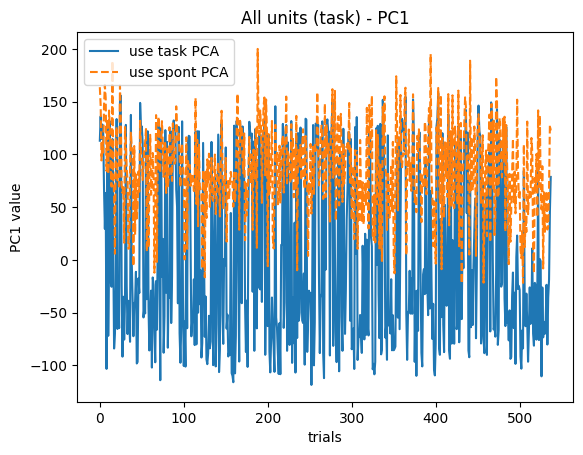

In [339]:
transformed_data = pca.transform(trial_da.data.reshape(trial_da.data.shape[0], -1).T)
transformed_data_by_spont = pca_spont.transform(trial_da.data.reshape(trial_da.data.shape[0], -1).T)
fig,ax=plt.subplots(1,1)
ax.plot(transformed_data[:,0], label='use task PCA')
ax.plot(transformed_data_by_spont[:,0], linestyle='--', label='use spont PCA')
ax.set_title('All units (task) - PC1')
ax.set_xlabel('trials')
ax.set_ylabel('PC1 value')
ax.legend()

In [340]:
#do PCA per structure, then correlate PC1s across structures
structures=units_filtered['structure'].unique()
structure_pca_results={}
structure_pca_results_spont={}
for structure in structures:
    units_in_structure=units_filtered[units_filtered['structure']==structure]['unit_id'].unique()
    if len(units_in_structure)<10:
        continue
    
    structure_da=trial_da.sel(unit_id=units_in_structure)

    pca = PCA()
    pca.fit(structure_da.data.reshape(structure_da.data.shape[0], -1).T)
    transformed_data_structure = pca.transform(structure_da.data.reshape(structure_da.data.shape[0], -1).T)

    structure_pca_results[structure]=transformed_data_structure

    # Perform PCA on spontaneous activity
    spont_structure_da=spont_trial_da.sel(unit_id=units_in_structure)
    pca_spont = PCA()
    pca_spont.fit(spont_structure_da.data.reshape(spont_structure_da.data.shape[0], -1).T)
    transformed_data_structure_spont = pca_spont.transform(spont_structure_da.data.reshape(spont_structure_da.data.shape[0], -1).T)

    structure_pca_results_spont[structure]=transformed_data_structure_spont

Text(0, 0.5, 'PC1 value')

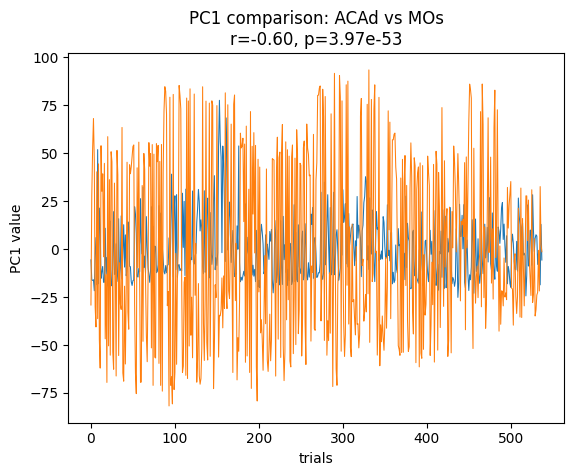

In [342]:
sel_structure_1='ACAd'
sel_structure_2='MOs'
fig,ax=plt.subplots(1,1)

structure_1_PC1=structure_pca_results[sel_structure_1][:,0]
structure_2_PC1=structure_pca_results[sel_structure_2][:,0]

r,p=stats.pearsonr(structure_1_PC1, structure_2_PC1)

ax.plot(structure_1_PC1, label=sel_structure_1, linewidth=0.75)
ax.plot(structure_2_PC1, label=sel_structure_2, linewidth=0.75)
ax.set_title(f'PC1 comparison: {sel_structure_1} vs {sel_structure_2}\nr={r:.2f}, p={p:.2e}')
ax.set_xlabel('trials')
ax.set_ylabel('PC1 value')

In [343]:
#get correlation between every pair of structures
structure_list=np.sort(list(structure_pca_results.keys()))
n_structures=len(structure_list)
task_corr_all_pairs=np.zeros((n_structures, n_structures))
spont_corr_all_pairs=np.zeros((n_structures, n_structures))
for i in range(n_structures):
    for j in range(n_structures):
        if i==j:
            task_corr_all_pairs[i,j]=np.nan
            spont_corr_all_pairs[i,j]=np.nan
            continue
        structure_i_PC1=structure_pca_results[structure_list[i]][:,0]
        structure_j_PC1=structure_pca_results[structure_list[j]][:,0]
        r_task,p_task=stats.pearsonr(structure_i_PC1, structure_j_PC1)
        task_corr_all_pairs[i,j]=r_task
        # compute spontaneous correlation
        structure_i_PC1=structure_pca_results_spont[structure_list[i]][:,0]
        structure_j_PC1=structure_pca_results_spont[structure_list[j]][:,0]
        r_spont,p_spont=stats.pearsonr(structure_i_PC1, structure_j_PC1)
        spont_corr_all_pairs[i,j]=r_spont


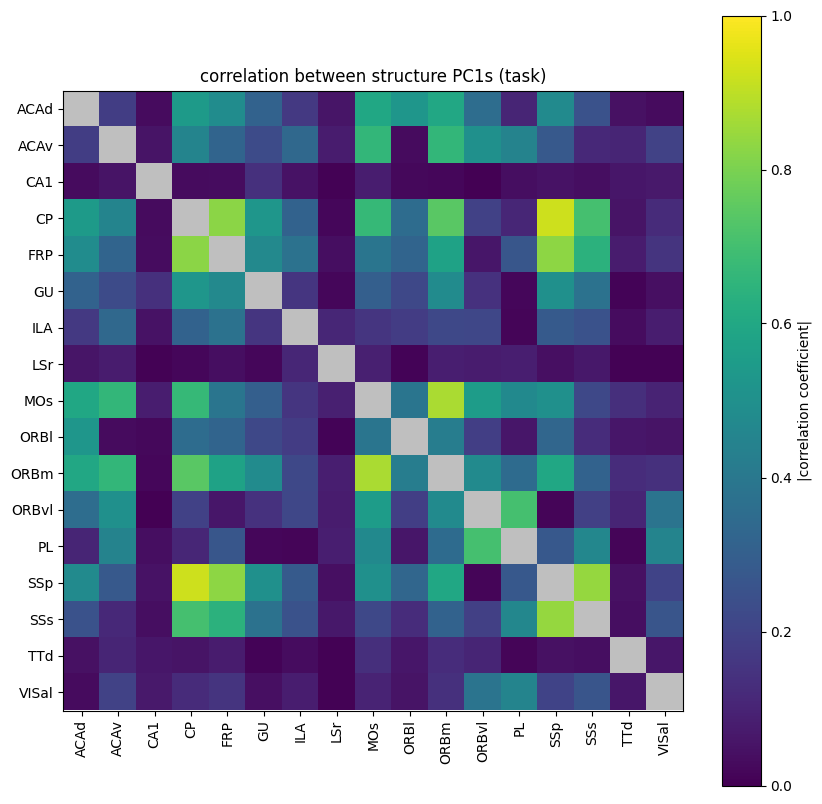

In [344]:
input_matrix=np.abs(task_corr_all_pairs)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(10,10))

im=ax.imshow(input_matrix, cmap=cmap, vmin=0, vmax=1.0)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)
ax.set_title('correlation between structure PC1s (task)')

fig.colorbar(im, ax=ax, label='|correlation coefficient|')

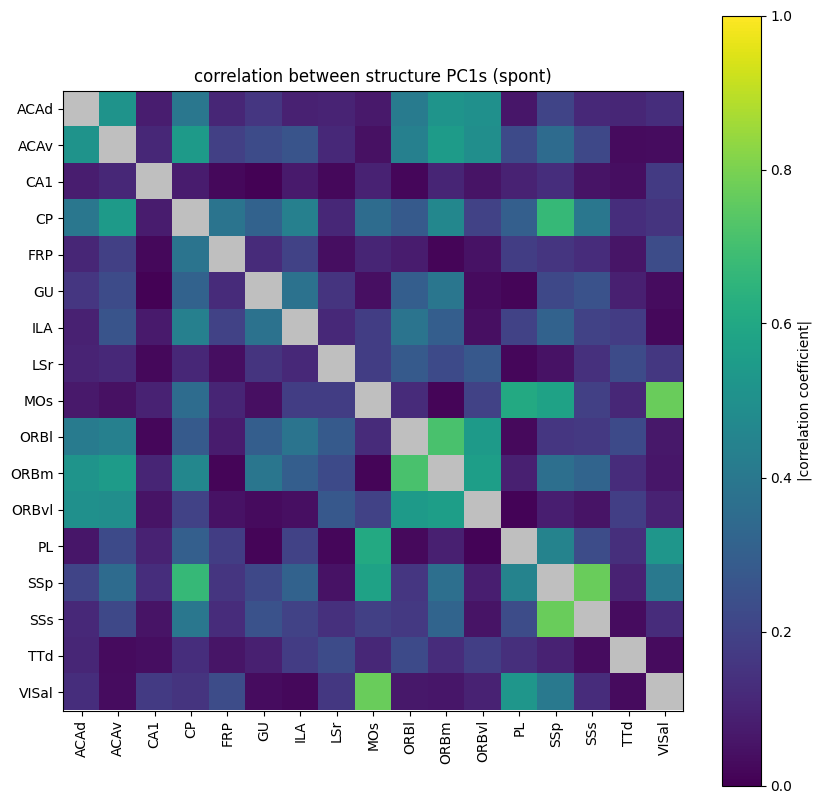

In [345]:
input_matrix=np.abs(spont_corr_all_pairs)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.viridis
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(10,10))

im=ax.imshow(input_matrix, cmap=cmap, vmin=0, vmax=1.0)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)
ax.set_title('correlation between structure PC1s (spont)')

fig.colorbar(im, ax=ax, label='|correlation coefficient|')

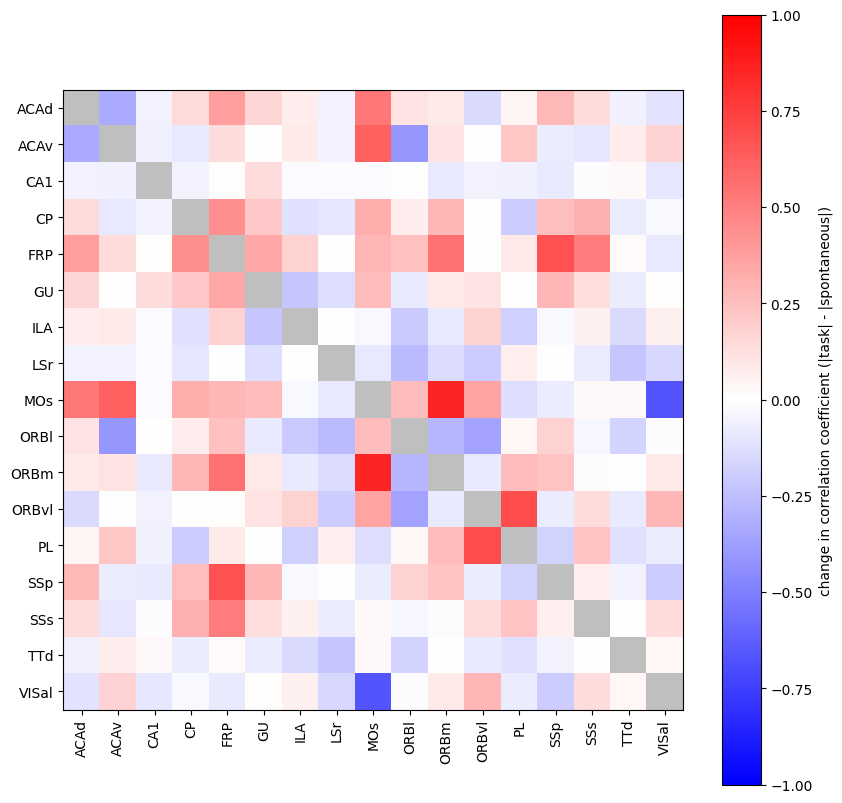

In [346]:
input_matrix=np.abs(task_corr_all_pairs)-np.abs(spont_corr_all_pairs)

import matplotlib
masked_array = np.ma.array(input_matrix, mask=np.isnan(input_matrix))
cmap = matplotlib.cm.bwr
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(10,10))

im=ax.imshow(input_matrix, cmap=cmap, vmin=-1.0, vmax=1.0)

ax.set_xticks(np.arange(n_structures))
ax.set_xticklabels(structure_list, rotation=90)
ax.set_yticks(np.arange(n_structures))
ax.set_yticklabels(structure_list)

fig.colorbar(im, ax=ax, label='change in correlation coefficient (|task| - |spontaneous|)')

In [347]:
corr_all_pairs=np.corrcoef(trial_da.data.reshape(trial_da.data.shape[0], -1))

In [348]:
corr_all_pairs.shape

(1442, 1442)

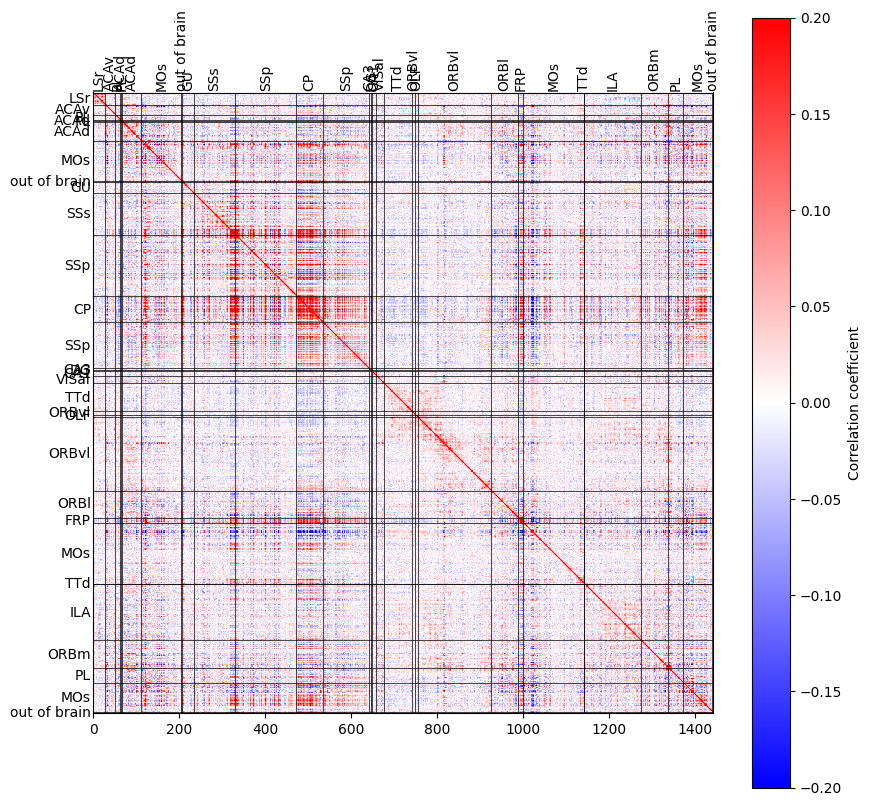

In [349]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.imshow(corr_all_pairs, cmap='bwr', vmin=-0.2, vmax=0.2)

#add structure boundaries and labels
structure_boundaries = []
structure_labels = []
current_structure = units_filtered.iloc[0]['structure']
for i, row in units_filtered.reset_index().iterrows():
    if row['structure'] != current_structure:
        structure_boundaries.append(i)
        structure_labels.append(current_structure)
        current_structure = row['structure']

#add labels to plot
for boundary in structure_boundaries:
    ax.axhline(boundary, color='k', linestyle='-',linewidth=0.5)
    ax.axvline(boundary, color='k', linestyle='-',linewidth=0.5)
midpoints = []
start = 0
for boundary in structure_boundaries + [len(units_filtered)]:
    midpoints.append((start + boundary) / 2)
    start = boundary
for midpoint, label in zip(midpoints, structure_labels + [current_structure]):
    ax.text(midpoint, -5, label, ha='center', va='bottom', rotation=90)
    ax.text(-5, midpoint, label, ha='right', va='center')

ax.set_yticks([])

#colorbar
cbar = fig.colorbar(im, ax=ax,)
cbar.set_label('Correlation coefficient')


In [350]:
spont_corr_all_pairs=np.corrcoef(spont_trial_da.data.reshape(spont_trial_da.data.shape[0], -1))

c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_7568\2907348689.py:30: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 1000x1000 with 2 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, ax=ax)


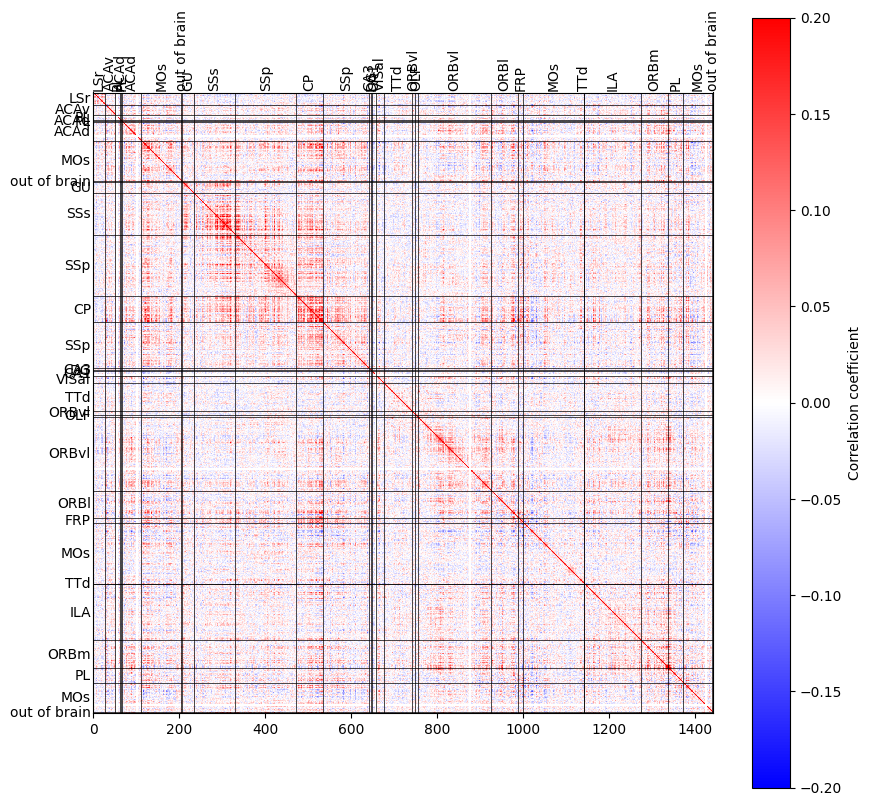

In [351]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(spont_corr_all_pairs, cmap='bwr', vmin=-0.3, vmax=0.3)

#add structure boundaries and labels
structure_boundaries = []
structure_labels = []
current_structure = units_filtered.iloc[0]['structure']
for i, row in units_filtered.reset_index().iterrows():
    if row['structure'] != current_structure:
        structure_boundaries.append(i)
        structure_labels.append(current_structure)
        current_structure = row['structure']

#add labels to plot
for boundary in structure_boundaries:
    ax.axhline(boundary, color='k', linestyle='-',linewidth=0.5)
    ax.axvline(boundary, color='k', linestyle='-',linewidth=0.5)
midpoints = []
start = 0
for boundary in structure_boundaries + [len(units_filtered)]:
    midpoints.append((start + boundary) / 2)
    start = boundary
for midpoint, label in zip(midpoints, structure_labels + [current_structure]):
    ax.text(midpoint, -5, label, ha='center', va='bottom', rotation=90)
    ax.text(-5, midpoint, label, ha='right', va='center')

ax.set_yticks([])

#colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Correlation coefficient')

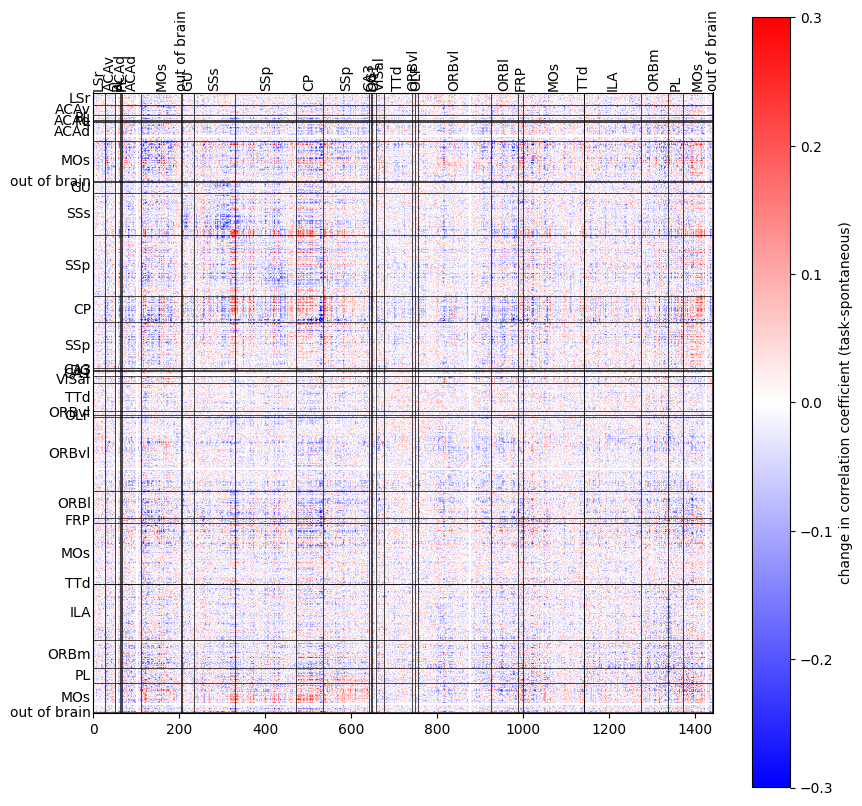

In [352]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
im=ax.imshow(corr_all_pairs-spont_corr_all_pairs, cmap='bwr', vmin=-0.3, vmax=0.3)

#add structure boundaries and labels
structure_boundaries = []
structure_labels = []
current_structure = units_filtered.iloc[0]['structure']
for i, row in units_filtered.reset_index().iterrows():
    if row['structure'] != current_structure:
        structure_boundaries.append(i)
        structure_labels.append(current_structure)
        current_structure = row['structure']

#add labels to plot
for boundary in structure_boundaries:
    ax.axhline(boundary, color='k', linestyle='-',linewidth=0.5)
    ax.axvline(boundary, color='k', linestyle='-',linewidth=0.5)
midpoints = []
start = 0
for boundary in structure_boundaries + [len(units_filtered)]:
    midpoints.append((start + boundary) / 2)
    start = boundary
for midpoint, label in zip(midpoints, structure_labels + [current_structure]):
    ax.text(midpoint, -5, label, ha='center', va='bottom', rotation=90)
    ax.text(-5, midpoint, label, ha='right', va='center')

ax.set_yticks([])

#colorbar
cbar = fig.colorbar(im, ax=ax,)
cbar.set_label('change in correlation coefficient (task-spontaneous)')


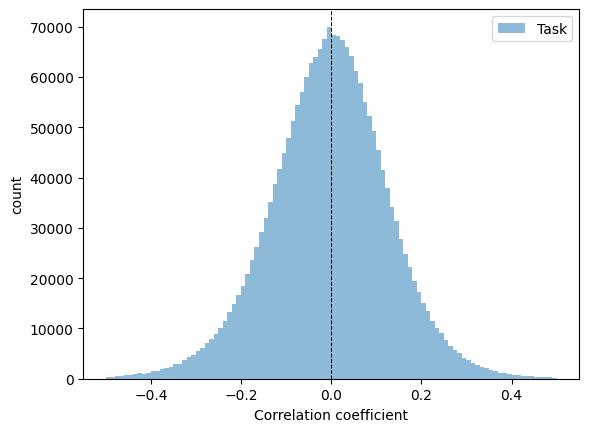

In [252]:
xbins=np.arange(-0.5,0.51,0.01)

fig,ax=plt.subplots(1,1)
ax.axvline(0, color='k', linestyle='--', linewidth=0.75)
# ax.hist(corr_all_pairs.flatten(), bins=xbins, alpha=0.5, label='Task')
# ax.hist(spont_corr_all_pairs.flatten(), bins=xbins, alpha=0.5, label='Spontaneous')
ax.hist((corr_all_pairs-spont_corr_all_pairs).flatten(), bins=xbins, alpha=0.5, label='Task')
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('count')
ax.legend()

In [254]:
np.mean((corr_all_pairs-spont_corr_all_pairs).flatten())

-0.00424781288956693